In [3]:
import os
import pandas as pd
import numpy as np
import faiss
import time
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

start_time = time.time()

# Define as categorias de atributos a serem consideradas
atr = ["TI", "MJ", "MN", "AB", "EX"]

# Cria um DataFrame vazio para armazenar os dados dos documentos
df_documentos = pd.DataFrame(columns=['PN', 'Text'])

# Diretório dos arquivos de documentos
diretorio_documentos = './cfc'

# Itera pelos arquivos de documentos no diretório
for arquivo in os.listdir(diretorio_documentos):
    if arquivo.endswith(".txt"):
        # Lê o arquivo
        with open(os.path.join(diretorio_documentos, arquivo), encoding='latin') as f:
            linhas = f.readlines()

        # Encontra os índices de cada PN
        indices = [i for i, linha in enumerate(linhas) if linha.startswith('PN')]
        
        # Monta uma lista de listas a partir de cada PN
        lista_pn = []
        ultimo_valor = 0
        for i in indices[1:]:
            lista_pn.append(linhas[ultimo_valor:i])
            ultimo_valor = i
        lista_pn.append(linhas[ultimo_valor:])
        
        # Monta o DataFrame
        for cada_lista in lista_pn:
            pn = cada_lista[0].replace("PN ", "").replace("\n", "")
            texto = ''
            atributo_selecionado = False
            for linha in cada_lista:
                if linha[:2] in atr:
                    atributo_selecionado = True
                elif linha[:2] != '  ' and linha[:2] not in atr:
                    atributo_selecionado = False
                if (linha[:2] == '  ' or linha[:2] in atr) and atributo_selecionado:
                    texto += linha[2:]
            novo_registro = pd.DataFrame([{'PN': pn, 'Text': texto.replace("\n", "")}])
            df_documentos = pd.concat([df_documentos, novo_registro], ignore_index=True)

# Salva os dados dos documentos em um arquivo CSV
df_documentos.to_csv('documentos.csv', index=False)

# Lê os dados de consulta
with open('cfc/cfquery.txt', encoding='utf-8') as arquivo_consulta:
    texto_consulta = arquivo_consulta.read()

# Processa os dados de consulta
df_consulta = pd.DataFrame(columns=['QN', 'Query', 'N_docs', 'Docs'])
for registro in texto_consulta.split("QN")[1:]:
    n_query = registro[1:6]
    query = registro[6:].split("\nNR")[0].replace("\n", "")[3:]
    n_docs = int(registro.split('NR')[1].split("\nRD")[0])
    docs = [int(d) for d in list(filter(lambda d: d != "", registro.split("\nRD")[1].replace("\n   ", "").replace("  ", " ").replace("\n", "").split(" ")))[::2]]
    novo_registro = pd.DataFrame([{'QN': n_query, 'Query': query, 'N_docs': n_docs, 'Docs': docs}])
    df_consulta = pd.concat([df_consulta, novo_registro], ignore_index=True)

# Converte tipos de dados
df_consulta['QN'] = df_consulta['QN'].astype('int64')
df_consulta['N_docs'] = df_consulta['N_docs'].astype('int64')

# Salva os dados de consulta em um arquivo CSV
df_consulta.to_csv('consulta.csv', index=False)

# Processa os textos dos documentos para vetorização TF-IDF
texto_documentos = df_documentos['Text']
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)
tf_idf = vectorizer.fit_transform(texto_documentos).toarray()

# Obtém o número de atributos TF-IDF
d1 = tf_idf.shape[1]

# Cria um índice Faiss para TF-IDF
ids = df_documentos.index.values.astype(np.int64)
tf_idf = tf_idf.astype(np.float32)
faiss.normalize_L2(tf_idf)
index_tfidf = faiss.IndexFlatIP(d1)
index_tfidf = faiss.IndexIDMap(index_tfidf)
index_tfidf.add_with_ids(tf_idf, ids)

# Processa os textos dos documentos para embeddings de sentença
modelo_sentenca = SentenceTransformer('all-MiniLM-L6-v2')
embeddings_sentenca = modelo_sentenca.encode(texto_documentos)
d2 = embeddings_sentenca.shape[1]

# Cria um índice Faiss para embeddings de sentença
faiss.normalize_L2(embeddings_sentenca)
index_sentenca = faiss.IndexFlatIP(d2)
index_sentenca = faiss.IndexIDMap(index_sentenca)
index_sentenca.add_with_ids(embeddings_sentenca, ids)

# Realiza a pesquisa nos documentos usando TF-IDF e embeddings de sentença
resultados_tfidf = []
resultados_sentenca = []

consultas = df_consulta['Query']
consultas_tfidf = vectorizer.transform(consultas).toarray().astype('float32')
faiss.normalize_L2(consultas_tfidf)
consultas_sentenca = modelo_sentenca.encode(consultas).astype('float32')
faiss.normalize_L2(consultas_sentenca)

for consulta_tfidf, consulta_sentenca, n_docs in zip(consultas_tfidf, consultas_sentenca, df_consulta['N_docs']):
    D_tfidf, I_tfidf = index_tfidf.search(consulta_tfidf.reshape(1, -1), n_docs)
    D_sentenca, I_sentenca = index_sentenca.search(consulta_sentenca.reshape(1, -1), n_docs)
    resultados_tfidf.append(I_tfidf[0].tolist())
    resultados_sentenca.append(I_sentenca[0].tolist())

# Adiciona os resultados à DataFrame de consulta
df_consulta['Search_docs_I2_TFIDF'] = resultados_tfidf
df_consulta['Search_docs_I2_Embeddings'] = resultados_sentenca

# Salva os resultados em um arquivo CSV
df_consulta.to_csv('resultados_consulta.csv', index=False)

# Tempo de execução
end_time = time.time()
execution_time = end_time - start_time

/home/fundecc/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/fundecc/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/fundecc/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


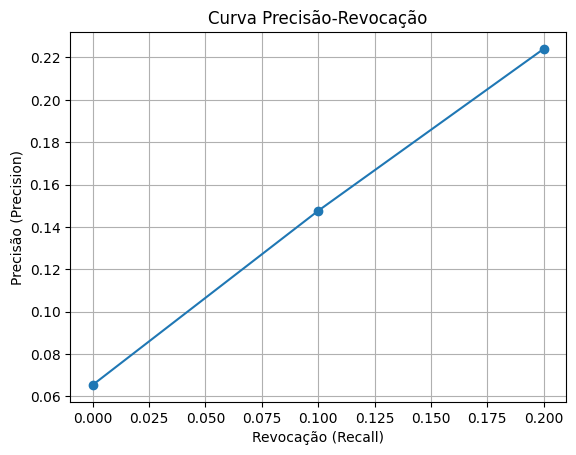

Tempo de execução: 71.6701557636261 segundos
Media precision 5: [0.074 0.112]
Media precision 10: [0.075 0.092]
Media MRR: [0.20346076 0.24525183]


In [4]:

def evaluate_metrics(relevant, retrieved, n_docs):
    tp = len(set(relevant).intersection(set(retrieved)))
    precision = tp / n_docs if n_docs > 0 else 0
    recall = tp / len(relevant) if len(relevant) > 0 else 0
    return precision, recall

def calculate_mrr(relevant, retrieved):
    for rank, doc in enumerate(retrieved, start=1):
        if doc in relevant:
            return 1 / rank
    return 0

# Avaliação das métricas
precision_at_5 = []
precision_at_10 = []
mrr_scores = []
precision_r_values = []

for query, relevant, retrieved_tfidf, retrieved_sentenca, n_docs in zip(
    df_consulta['Query'],
    df_consulta['Docs'],
    df_consulta['Search_docs_I2_TFIDF'],
    df_consulta['Search_docs_I2_Embeddings'],
    df_consulta['N_docs']
):
    precision_tfidf, recall_tfidf = evaluate_metrics(relevant, retrieved_tfidf, n_docs)
    precision_sentenca, recall_sentenca = evaluate_metrics(relevant, retrieved_sentenca, n_docs)
    
    # P@5 e P@10
    p_at_5_tfidf = len(set(relevant).intersection(set(retrieved_tfidf[:5]))) / 5
    p_at_10_tfidf = len(set(relevant).intersection(set(retrieved_tfidf[:10]))) / 10
    p_at_5_sentenca = len(set(relevant).intersection(set(retrieved_sentenca[:5]))) / 5
    p_at_10_sentenca = len(set(relevant).intersection(set(retrieved_sentenca[:10]))) / 10
    
    precision_at_5.append((p_at_5_tfidf, p_at_5_sentenca))
    precision_at_10.append((p_at_10_tfidf, p_at_10_sentenca))
    
    # MRR
    mrr_tfidf = calculate_mrr(relevant, retrieved_tfidf)
    mrr_sentenca = calculate_mrr(relevant, retrieved_sentenca)
    
    mrr_scores.append((mrr_tfidf, mrr_sentenca))
    
    # Precisão-R
    precision_r_values.append([precision_tfidf, precision_sentenca])

# Calcula métricas médias
avg_precision_at_5 = np.mean(precision_at_5, axis=0)
avg_precision_at_10 = np.mean(precision_at_10, axis=0)
avg_mrr_scores = np.mean(mrr_scores, axis=0)


print(f'Tempo de execução: {execution_time} segundos')
print(f'Media precision 5: {avg_precision_at_5}')
print(f'Media precision 10: {avg_precision_at_10}')
print(f'Media MRR: {avg_mrr_scores}')